# Classification methods for hypertension prediction - Part II - Noise detection

In [8]:
%matplotlib inline

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from itertools import cycle

In [10]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report

from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA

### Introduction

In this part I am going to use the same machine learning methods in order to predict high blood pressure from clinical data in a different dataset. I am going to try some additional techniques such as principal component analysis which can probably help to find noise in data. The data tiding and preprocessing steps are similar to those in the first part. This time I am going to process the target column in such way that it becomes binary classification problem.

### Data preprocessing

##### Data desciption 

As this dataset does not have a description provided, I am going to retrieve as much information as possible from the available data.

Features:
   1. Age - AGE - int (years)
   2. Gender - GENDER - int (1:female, 0: male) 
   3. Waist - WAIST - float (cm) 
   4. Systolic blood pressure - BP_HIGH - float(mmHg)
   5. Diastolic blood pressure - BP_LOW - float(mmHg)
   6. Total cholesterol - TOT_CHOLE - float (mg/dl)
   7. Aspartate Aminotransferase - AST - float (IU/L)
   8. Alanine Aminotransferase - ALT - float (IU/L) 
   9. Gamma-Glutamyl Transferase (GGT)- GTP - float (IU/L)
   10. Hemoglobin - HMG - float (mmol/L)
   11. Physical activity - EXER_M - int (1: never, 2: once a week, 3: 2-3 a week, 4: 4-5 a week, 5: '>5 a week')


The blood pressure data was derived from __[kaggle](https://www.kaggle.com/kmukhammadjon/hypertension-incidence-in-two-and-half-years)__.

In [11]:
bp_data = pd.read_csv('data/MGE303_Term Project_Classification_Data (Disease).csv')

###### Becomng acquainted with the data and data cleaning

I am going to follow the same sequence of tasks to get overall information about the data as in the first part of the project: number of observations, data description, finding and handling missing values, finding duplicate values, identifying closely related features with correlation matrix. Additionally, I am going to remove irrelevant columns. There are several columns with ambiguous information. Although I can conclude that they contain information about the presence of chronic disease and diabetes, I cannot be sure what are the values indicating. I will also rename the remaining columns, again convert values in the gender column, get dummy variables, selecting the target column with blood pressure classification and perform normalization. I am going to make a binary classification problem with high blood pressure considered above 120 systolic and above 80 diastolic.

In [12]:
bp_data.head()

,HY_YN,AGE,gender,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,SGOT_ASL,SGPT_ALT,...,H_APOP_YN,H_HDISE_YN,H_DIABML_YN,F_APOP_YN,F_HDISE_YN,F_HPRT_YN,F_DIABML_YN,DSQTY,SMK_TERM,EXER_M
0,1,66,1,76.0,120.0,70.0,87.0,199.0,22.0,13.0,...,0,0,0,0,0,0,0,0,5,Once a week
1,1,55,1,84.0,110.0,80.0,85.0,178.0,40.0,35.0,...,0,0,0,0,0,0,0,0,0,Never
2,1,54,0,84.0,117.0,76.0,92.0,195.0,20.0,20.0,...,0,0,0,0,0,0,0,0,0,Once a week
3,1,29,1,80.0,126.0,82.0,86.0,150.0,25.0,27.0,...,0,0,0,0,0,0,0,1,3,Once a week
4,1,43,1,82.0,130.0,85.0,104.0,134.0,31.0,23.0,...,0,0,0,0,0,0,0,2,3,Once a week


In [13]:
#derive the column names for further use
bp_data.columns

Index(['HY_YN', 'AGE', 'gender', 'WAIST', 'BP_HIGH', 'BP_LWST', 'BLDS',
       'TOT_CHOLE', 'SGOT_ASL', 'SGPT_ALT', 'GAMMA_GTP', 'HMG', 'H_APOP_YN',
       'H_HDISE_YN', 'H_DIABML_YN', 'F_APOP_YN', 'F_HDISE_YN', 'F_HPRT_YN',
       'F_DIABML_YN', 'DSQTY', 'SMK_TERM', 'EXER_M'],
      dtype='object')

In [14]:
#remove ambiguous information in the dataset
bp_data.drop(columns=['HY_YN', 'BLDS', 'H_APOP_YN',
       'H_HDISE_YN', 'H_DIABML_YN', 'F_APOP_YN', 'F_HDISE_YN', 'F_HPRT_YN',
       'F_DIABML_YN', 'DSQTY', 'SMK_TERM'], inplace=True)

In [15]:
bp_data = bp_data.rename(columns = {'gender': 'GENDER', 'BP_LWST': 'BP_LOW', 'gender': 'GENDER', 'BP_LWST': 'BP_LOW',
                                   'SGOT_ASL': 'AST', 'SGPT_ALT': 'ALT', 'GAMMA_GTP':'GTP'}, inplace = False)

In [16]:
bp_data.columns

Index(['AGE', 'GENDER', 'WAIST', 'BP_HIGH', 'BP_LOW', 'TOT_CHOLE', 'AST',
       'ALT', 'GTP', 'HMG', 'EXER_M'],
      dtype='object')

In [17]:
bp_data.shape

(21613, 11)

I will check if there are any NaN values and remove these as the number of observations is sufficient.

In [18]:
bp_data.isnull().sum()

AGE           0
GENDER        0
WAIST        44
BP_HIGH       3
BP_LOW        3
TOT_CHOLE     0
AST          27
ALT          22
GTP          81
HMG           6
EXER_M        0
dtype: int64

There are some missing values so I am going to remove the entries that contain any of them.

In [19]:
bp_data.dropna(inplace=True)

In [20]:
bp_data.shape

(21451, 11)

Finally, I will check for duplicated data if any

In [21]:
bp_data.duplicated().sum()

0

In [22]:
bp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,21451.0,42.606126,11.605487,20.0,33.0,42.0,51.0,69.0
GENDER,21451.0,0.580393,0.493506,0.0,0.0,1.0,1.0,1.0
WAIST,21451.0,79.591954,8.999019,5.0,73.0,80.0,86.0,122.0
BP_HIGH,21451.0,118.823878,11.373155,80.0,110.0,120.0,130.0,139.0
BP_LOW,21451.0,74.290662,7.949006,42.0,70.0,75.0,80.0,89.0
TOT_CHOLE,21451.0,191.653956,35.521616,66.0,167.0,189.0,213.0,468.0
AST,21451.0,24.089506,10.310355,2.0,18.0,22.0,27.0,187.0
ALT,21451.0,24.614657,17.519615,2.0,14.0,20.0,29.0,198.0
GTP,21451.0,33.495734,32.143388,2.0,15.0,23.0,38.0,300.0
HMG,21451.0,14.065195,1.603039,1.5,13.0,14.1,15.3,19.2


According to the dataset description, the only column that needs to have values constrained is the 'waist' column which contains some impossible values. that I am going to remove along with the whole observation.

In [23]:
bp_data = bp_data.drop(bp_data[(bp_data['WAIST'] < 45)].index)

In [24]:
bp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,21449.0,42.604317,11.604501,20.0,33.0,42.0,51.0,69.0
GENDER,21449.0,0.580353,0.493513,0.0,0.0,1.0,1.0,1.0
WAIST,21449.0,79.598723,8.972073,46.0,73.0,80.0,86.0,122.0
BP_HIGH,21449.0,118.825167,11.372799,80.0,110.0,120.0,130.0,139.0
BP_LOW,21449.0,74.291063,7.948682,42.0,70.0,75.0,80.0,89.0
TOT_CHOLE,21449.0,191.653923,35.522637,66.0,167.0,189.0,213.0,468.0
AST,21449.0,24.088489,10.309750,2.0,18.0,22.0,27.0,187.0
ALT,21449.0,24.613409,17.519433,2.0,14.0,20.0,29.0,198.0
GTP,21449.0,33.494056,32.142690,2.0,15.0,23.0,38.0,300.0
HMG,21449.0,14.065127,1.603024,1.5,13.0,14.1,15.3,19.2


In [25]:
#check if the categories in the categorical columns are correct
for column in ['GENDER', 'EXER_M']:
    print(bp_data.groupby(column)[column].count())

GENDER
0     9001
1    12448
Name: GENDER, dtype: int64
EXER_M
2-3 a week      2543
4-5 a week       624
>5 a week        783
Never          10781
Once a week     6718
Name: EXER_M, dtype: int64


In [26]:
bp_data.dtypes

AGE            int64
GENDER         int64
WAIST        float64
BP_HIGH      float64
BP_LOW       float64
TOT_CHOLE    float64
AST          float64
ALT          float64
GTP          float64
HMG          float64
EXER_M        object
dtype: object

Most of the columns in the dataset contain values of numerical type, except for the exercise column which I am going to cope with by getting dummies.

In [27]:
bp_data.head(30)

,AGE,GENDER,WAIST,BP_HIGH,BP_LOW,TOT_CHOLE,AST,ALT,GTP,HMG,EXER_M
0,66,1,76.0,120.0,70.0,199.0,22.0,13.0,22.0,15.0,Once a week
1,55,1,84.0,110.0,80.0,178.0,40.0,35.0,72.0,14.9,Never
2,54,0,84.0,117.0,76.0,195.0,20.0,20.0,15.0,13.3,Once a week
3,29,1,80.0,126.0,82.0,150.0,25.0,27.0,35.0,17.0,Once a week
4,43,1,82.0,130.0,85.0,134.0,31.0,23.0,46.0,14.1,Once a week
5,66,1,78.0,130.0,76.0,188.0,26.0,13.0,63.0,14.1,Once a week
6,53,1,77.0,115.0,70.0,201.0,23.0,18.0,31.0,13.1,2-3 a week
7,47,1,81.0,120.0,80.0,172.0,43.0,37.0,118.0,16.6,Once a week
8,50,0,86.0,130.0,80.0,213.0,22.0,25.0,29.0,11.6,Never
9,56,1,105.0,138.0,85.0,197.0,19.0,22.0,20.0,14.3,Once a week


###### Correlations visualisation
For this dataset I am also going to plot a correlation matrix to see if there are any linear correlations in the data.

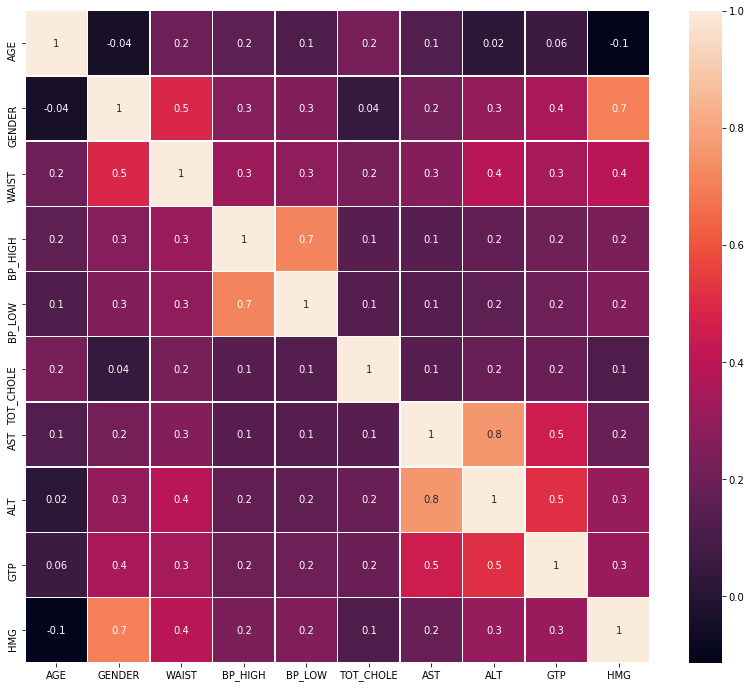

In [28]:
f, ax = plt.subplots(figsize = (14,12))
sns.heatmap(bp_data.corr(), annot = True, fmt='.1g', linewidths=0.5, ax=ax)

#fixing first and last row of the matrix as they are cut in half
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Obviously there is correlation between the low and high blood pressure values and also between the different types of liver enzymes. Also a correlation between hemoglobin values, gender and waist can be seen. This is also expected as men have higher reference ranges of blood hemoglobin.

###### Preparing feature and target data for machine learning

If just one of the blood pressure readings (systolic or diastolic) is higher than normal, this is considered prehypertension or hypertension. Because of this, classification of blood pressure can be done based on the sum of both readings. What is more, taking the sum is a way to keep blood pressure values with mistakenly reversed systolic and diastolic readings (diastolic blood pressure cannot be higher than systolic).

In [29]:
#preparing the target column
bp_data['hypertension'] = bp_data.BP_HIGH + bp_data.BP_LOW
bp_data['hypertension'] = bp_data['hypertension'].apply(lambda x: 0 if x <= 200 else 1)

In [30]:
bp_data

,AGE,GENDER,WAIST,BP_HIGH,BP_LOW,TOT_CHOLE,AST,ALT,GTP,HMG,EXER_M,hypertension
0,66,1,76.0,120.0,70.0,199.0,22.0,13.0,22.0,15.0,Once a week,0
1,55,1,84.0,110.0,80.0,178.0,40.0,35.0,72.0,14.9,Never,0
2,54,0,84.0,117.0,76.0,195.0,20.0,20.0,15.0,13.3,Once a week,0
3,29,1,80.0,126.0,82.0,150.0,25.0,27.0,35.0,17.0,Once a week,1
4,43,1,82.0,130.0,85.0,134.0,31.0,23.0,46.0,14.1,Once a week,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21608,36,1,85.0,130.0,80.0,185.0,15.0,18.0,50.0,15.4,Never,1
21609,31,0,67.0,102.0,68.0,164.0,13.0,11.0,13.0,13.9,Never,0
21610,42,1,71.0,118.0,76.0,192.0,19.0,10.0,18.0,14.1,Never,0
21611,34,0,63.0,106.0,66.0,190.0,19.0,15.0,13.0,13.1,Once a week,0


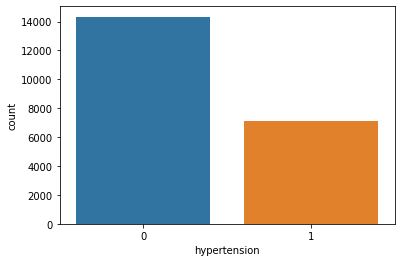

In [31]:
sns.countplot(x=bp_data['hypertension'])
plt.show()

The two classes have different number of entries and the dataset is imbalanced which means I will have to use one of the appropriate metrics.

In [32]:
# Separating features and target data
bp_data_features = bp_data.drop(columns=['BP_HIGH', 'BP_LOW', 'hypertension'])
bp_data_target = bp_data['hypertension']

In [33]:
bp_data_features.shape

(21449, 9)

In [34]:
bp_data_target.shape

(21449,)

In [35]:
bp_data_features = pd.get_dummies(bp_data_features, columns=['EXER_M'])

In [36]:
scaler = StandardScaler()
bp_data_features[['AGE', 'WAIST', 'TOT_CHOLE', 'AST',
       'ALT', 'GTP', 'HMG']] = scaler.fit_transform(bp_data_features[['AGE', 'WAIST', 'TOT_CHOLE', 'AST',
       'ALT', 'GTP', 'HMG']])

In [37]:
#remove the dummy columns that can be deduced from the others
bp_data_features.drop(columns = ["EXER_M_Never"], inplace = True)

In [38]:
bp_data_features

,AGE,GENDER,WAIST,TOT_CHOLE,AST,ALT,GTP,HMG,EXER_M_2-3 a week,EXER_M_4-5 a week,EXER_M_>5 a week,EXER_M_Once a week
0,2.016134,1,-0.401112,0.206805,-0.202579,-0.662903,-0.357603,0.583207,0,0,0,1
1,1.068204,1,0.490564,-0.384381,1.543382,0.592875,1.197997,0.520824,0,0,0,0
2,0.982028,0,0.490564,0.094198,-0.396575,-0.263337,-0.575387,-0.477313,0,0,0,1
3,-1.172358,1,0.044726,-1.172630,0.088415,0.136229,0.046853,1.830878,0,0,0,1
4,0.034098,1,0.267645,-1.623057,0.670402,-0.092095,0.389085,0.021755,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21608,-0.569130,1,0.602024,-0.187319,-0.881564,-0.377499,0.513533,0.832742,0,0,0,0
21609,-1.000007,0,-1.404248,-0.778506,-1.075559,-0.777064,-0.637611,-0.103012,0,0,0,0
21610,-0.052077,1,-0.958410,0.009743,-0.493572,-0.834145,-0.482051,0.021755,0,0,0,0
21611,-0.741481,0,-1.850086,-0.046561,-0.493572,-0.548741,-0.637611,-0.602080,0,0,0,1


###### PCA analysis
Although not necessary as I don't have too many features in this dataset, I am going to prepare another set of data for learning that will have some of the more irrelevant components removed with principal component analysis (PCA). I am then going to train the same models on both the transformed data and the row data and to compare their performance.


In [39]:
poly_transformer = PolynomialFeatures(degree = 3, interaction_only = True)
bp_features_train_polynomial = poly_transformer.fit_transform(bp_data_features)

In [40]:
pca = PCA()

In [41]:
bp_features_poly_pca = pca.fit(bp_features_train_polynomial)

I am going to plot the results from the pca transformation so I can see how many of the components are enough for use when training the machine learning models.

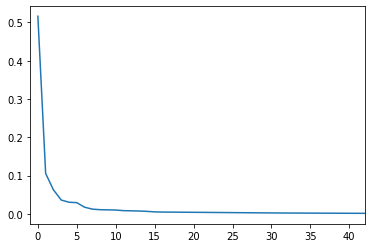

In [42]:
plt.plot(pca.explained_variance_ratio_)
plt.xlim(-1,42)
plt.show()

It is evident from the plot that more than 20 components will not contribute more to the explained variance.

In [43]:
pca_components = PCA(n_components=25)

In [44]:
bp_features_poly_pca = pca_components.fit_transform(bp_features_train_polynomial)

In [45]:
np.cumsum(pca_components.explained_variance_ratio_)

array([0.51620629, 0.62185735, 0.68471587, 0.7209865 , 0.75152142,
       0.78089249, 0.79840414, 0.81089962, 0.82194225, 0.83257779,
       0.8427018 , 0.8512432 , 0.8593864 , 0.8669877 , 0.873658  ,
       0.87897493, 0.88382193, 0.88849048, 0.89293037, 0.89708973,
       0.90115187, 0.90504815, 0.90875245, 0.91221236, 0.91557323])

### Machine learning methods exploration

###### Data splitting and interaction

The idea is first to split the data to test and train sets, and after that - to create a stratified k-fold split object so it can be used later for cross-validation. I will first split the raw and then the polynomai features and PCA transformed data.

In [46]:
bp_features_train, bp_features_test, bp_target_train, bp_target_test = train_test_split(
    bp_data_features, bp_data_target, train_size = 0.8, stratify = bp_data_target)

In [47]:
bp_features_train.shape

(17159, 12)

In [48]:
bp_features_test.shape

(4290, 12)

In [49]:
bp_features_train_poly_pca, bp_features_test_poly_pca, bp_target_train_poly_pca, bp_target_test_poly_pca = train_test_split(
    bp_features_poly_pca, bp_data_target, train_size = 0.8, stratify = bp_data_target)

In [50]:
bp_features_train_poly_pca.shape

(17159, 25)

In [51]:
bp_features_test_poly_pca.shape

(4290, 25)

In [52]:
k_fold =  StratifiedKFold(n_splits = 5)

###### Fit and score function

I am going to define a function which will first perform grid search with predefined hyperparameters, using f1 score. Then the function will fit the model with the training data select best classifier depending on the validation results. After that the best classifier will be used to predict the testing data and compare the results to the testing target. Finally, it will print all scoring results with the given method name and return the best classifier.

In [53]:
def train_score_model (model, parameters, model_name, features_train, features_test, target_train, target_test):
    '''Fit model with selected parameters, score the performance and print the scoring results. Returns best classifier'''
    
    grid = GridSearchCV(model, param_grid = parameters, cv = k_fold, scoring = 'f1')
    
    grid_search = grid.fit(features_train, target_train)

    best_classifier = grid_search.best_estimator_
        
    print("{0} best score is {1}".format(model_name, grid_search.best_score_))

    test_classifier_score = f1_score(target_test, best_classifier.predict(features_test))
    print("For {0} the f1 score for the test data is {1}".format(model_name, test_classifier_score))
        
    return  best_classifier

###### Logistic Regression

Going further I will explore the performance of several types of machine learning algorithms this time including the Support Vector Machines method with the default Gaussian (RBF) Kernel. This is possible because the dataset is smaller than the one in the first part.

In [54]:
logistic_regression_model = LogisticRegression(solver = 'liblinear')

I am going to use a grid with different values for three hyperparameters: penalty, regularisation parameter C, and maximum number of iterations before convergence. I will first train the model with the raw data and then use the transformed (Poly and PCA) data and compare the results.

In [55]:
regression_parameters = {
    'penalty': ['l1', 'l2'],
    'C': [1e-3, 1e-1, 1, 100, 1e6],
    'max_iter': [100, 200, 500],
}

In [56]:
#train and score with raw data
logistic_best = train_score_model (logistic_regression_model, regression_parameters, 'logistic regression', bp_features_train, bp_features_test, bp_target_train, bp_target_test)

logistic regression best score is 0.28718129167655343
For logistic regression the f1 score for the test data is 0.28410256410256407


In [57]:
#train and score with transformed data
logistic_best_poly_pca = train_score_model (logistic_regression_model, regression_parameters, 'logistic regression', bp_features_train_poly_pca, bp_features_test_poly_pca, bp_target_train_poly_pca, bp_target_test_poly_pca)

logistic regression best score is 0.2567185836788916
For logistic regression the f1 score for the test data is 0.24331696672122205


###### Decision Tree
I am going to use the same parameter grid for the Decision Tree classifier as in the first part.

In [58]:
tree_model = DecisionTreeClassifier()

In [59]:
parameters_tree = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [3, 9, 14, 20, 30],
    "min_samples_leaf": [2, 5, 8, 12],
}

In [60]:
#train and score with raw data
tree_best = train_score_model (tree_model, parameters_tree, 'Decision Tree', bp_features_train, bp_features_test, bp_target_train, bp_target_test)

Decision Tree best score is 0.3832327486552226
For Decision Tree the f1 score for the test data is 0.3901701323251418


In [61]:
#train and score with transformed data
tree_best_poly_pca = train_score_model(tree_model, parameters_tree, 'Decision Tree', bp_features_train_poly_pca, bp_features_test_poly_pca, bp_target_train_poly_pca, bp_target_test_poly_pca)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

Decision Tree best score is 0.3783410484582038
For Decision Tree the f1 score for the test data is 0.3913043478260869


###### Random forest
Here as the dataset is smaller, I can add minimum samples per leaf in the parameter grid which will not make the alogorithms run very slowly.

In [62]:
forest_model = RandomForestClassifier()

In [63]:
parameters_forest = {
    "n_estimators": [100, 200, 500],
    "min_samples_leaf": [1, 2, 3]
}

In [64]:
#train and score with raw data
forest_best = train_score_model (forest_model, parameters_forest, 'Random Forest', bp_features_train, bp_features_test, bp_target_train, bp_target_test)

Random Forest best score is 0.2893684005371467
For Random Forest the f1 score for the test data is 0.30004870920603993


In [65]:
#train and score with transformed data
forest_best_poly_pca = train_score_model(forest_model, parameters_forest, 'Random Forest', bp_features_train_poly_pca, bp_features_test_poly_pca, bp_target_train_poly_pca, bp_target_test_poly_pca)

Random Forest best score is 0.28759607364027134
For Random Forest the f1 score for the test data is 0.3080684596577017


###### AdaBoost

In [66]:
boost_model = AdaBoostClassifier()

In [67]:
parameters_boost = {
    "n_estimators": [25, 50, 100, 200],
    "learning_rate": [0.01, 0.1, 1, 2],
}

In [68]:
#train and score with raw data
boost_best = train_score_model (boost_model, parameters_boost, 'AdaBoost', bp_features_train, bp_features_test, bp_target_train, bp_target_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

AdaBoost best score is 0.30918835890226987
For AdaBoost the f1 score for the test data is 0.5134610047182904


In [69]:
#train and score with transformed data
boost_best_poly_pca = train_score_model (boost_model, parameters_boost, 'AdaBoost', bp_features_train_poly_pca, bp_features_test_poly_pca, bp_target_train_poly_pca, bp_target_test_poly_pca)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

AdaBoost best score is 0.255047758896655
For AdaBoost the f1 score for the test data is 0.2476290832455216


###### Support vector machines
Here I can set both gamma and C hyperparameters which will control the margin hardness. In addition I can use the default radial basis function (RBF) kernel which makes a pojection into an infinite dimensional space.

In [70]:
svm_model = SVC()

In [71]:
parameters_svm = {
    "gamma": [0.01, 0.1, 1],
    "C": [1, 10, 100]
}

In [72]:
#train and score with raw data
svm_best = train_score_model (svm_model, parameters_svm, 'SVM', bp_features_train, bp_features_test, bp_target_train, bp_target_test)

SVM best score is 0.3566867477177397
For SVM the f1 score for the test data is 0.351947097722263


In [73]:
#train and score with transformed data
svm_best_poly_pca = train_score_model (svm_model, parameters_svm, 'SVM', bp_features_train_poly_pca, bp_features_test_poly_pca, bp_target_train_poly_pca, bp_target_test_poly_pca)

SVM best score is 0.2529216724325462
For SVM the f1 score for the test data is 0.26848249027237353


###### K-nearest neighbors classifier

In [74]:
knn_model = KNeighborsClassifier()

In [75]:
parameters_knn = {
    "n_neighbors": [3, 5, 7, 9]
}

In [76]:
#train and score with raw data
knn_best = train_score_model (knn_model, parameters_knn, 'kNN', bp_features_train, bp_features_test, bp_target_train, bp_target_test)

kNN best score is 0.3591090139252654
For kNN the f1 score for the test data is 0.3846761453396525


In [77]:
#train and score with transformed data
knn_best_poly_pca = train_score_model (knn_model, parameters_knn, 'kNN', bp_features_train_poly_pca, bp_features_test_poly_pca, bp_target_train_poly_pca, bp_target_test_poly_pca)

kNN best score is 0.3632949134815714
For kNN the f1 score for the test data is 0.3627797408716137


###### Results

All methods give very low results on both raw and transformed data which most probably means that it is not easily separated. The results are also not reproducible as the scores vary much between different kernel runs. The highest results on some runs come from the AdaBoost classifier (around 58%) but this applies only to the non-transformed data. The results are not sufficient to conclude that there is noise which can be removed with dimensionality reduction.

###### Feature importances
I am going to check the feature importances as predicted by the Decision Tree classifier which has consistently the highest scores (AdaBoost sometimes perform better but the results are highly inconsistent).

In [78]:
tree_best.fit(bp_data_features, bp_data_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [79]:
importances = tree_best.feature_importances_
features = list(bp_data_features.columns)
zipped = list(zip(features, importances))

pd.DataFrame(zipped, columns=['features','importances'])

,features,importances
0,AGE,0.123010
1,GENDER,0.023487
2,WAIST,0.161009
3,TOT_CHOLE,0.154026
4,AST,0.098395
5,ALT,0.121092
6,GTP,0.140903
7,HMG,0.144590
8,EXER_M_2-3 a week,0.008837
9,EXER_M_4-5 a week,0.001713


According to the Decision Tree classifier, the most important features are waist and total cholesterol. Other laboratory readings such as GTP and HMG are also somehow important.

###### Confusion Matrix

In [80]:
tree_best.fit(bp_features_train, bp_target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [81]:
predicted = tree_best.predict(bp_features_test)

In [82]:
#creating confusion matrix with labels set so that the classes correspond
confusion_matrix = confusion_matrix(bp_target_test, predicted, labels=[0, 1])

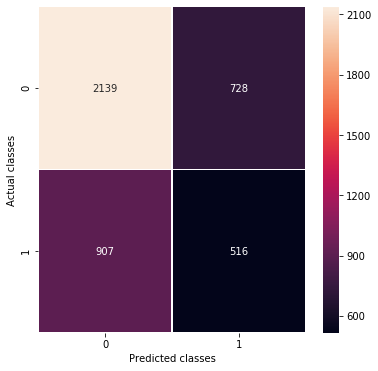

In [83]:
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix, fmt=".0f", annot=True, linewidths=0.5, ax=ax)

plt.xlabel("Predicted classes")
plt.ylabel("Actual classes")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

###### Scores

Here I am going to use the classification report to derive the scores of the model.

In [80]:
print(classification_report(bp_target_test, predicted, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      2867
           1       0.39      0.37      0.38      1423

    accuracy                           0.60      4290
   macro avg       0.54      0.54      0.54      4290
weighted avg       0.59      0.60      0.59      4290



##### Result interpretation

The Decision Tree classifier achieves best of the relevant scores (recall, precision and f1-score) for the first class which is the class of normal blood pressure. The results for prehypertension and especially for the hypertension classes are significantly lower. It seems that it is difficult for the method to distinguish between the medical data for pre- and hypertensive patients. It may also be deduced from the numbers in the confusion matrix that the model was misled from features implying borderline values of high blood pressure. 

### ROC Curve

Receiver Operating Characteristics (ROC) curve is a probability evaluation metric that reflects the performance of binary  classification problems.

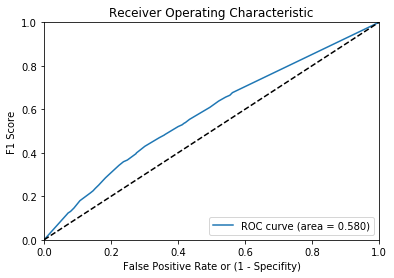

In [88]:
#obtain probabilities instead of target class
predicted_class = tree_best.fit(bp_features_train, bp_target_train).predict_proba(bp_features_test)[:, 1]
# Compute false positive rate, true positive rate, thresholds and roc area uunder the curve
fpr, tpr, thresholds = roc_curve(bp_target_test, predicted_class)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('F1 Score')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

###### Result interpretation
The ROC curve shows very low result, close to a random classifier.

### Resources:
1. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0240370
2. https://www.cdc.gov/bloodpressure/about.htm
3. https://www.sciencedirect.com/science/article/abs/pii/S0957417405000758
4. https://www.kaggle.com/kmukhammadjon/hypertension-incidence-in-two-and-half-years
5. https://www.kaggle.com/sulianova/cardiovascular-disease-dataset
6. https://www.kaggle.com/raminhashimzade/cardio-disease
7. https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d
8. https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
9. https://xavierbourretsicotte.github.io/AdaBoost.html
10. https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
11. https://medium.com/@mohtedibf/in-depth-parameter-tuning-for-knn-4c0de485baf6
12. https://dev.to/overrideveloper/understanding-the-confusion-matrix-264i
13. https://stackoverflow.com/questions/51378105/plot-multi-class-roc-curve-for-decisiontreeclassifier 
14. https://www.dataquest.io/blog/learning-curves-machine-learning/